In [14]:
import anndata as ad
from pronto import Ontology

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline


In [2]:
#adata = ad.read_h5ad('small_1044_900') # 42000 cells

adata = ad.read_h5ad('leaf_list_leukocyte_24Aug')

## Visualize the distribution of target cell IDs

In [3]:
adata

AnnData object with n_obs × n_vars = 516447 × 60664
    obs: 'cell_type_ontology_term_id', 'assay'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [4]:
ids = adata.obs['cell_type_ontology_term_id']

In [5]:
type(ids)

pandas.core.series.Series

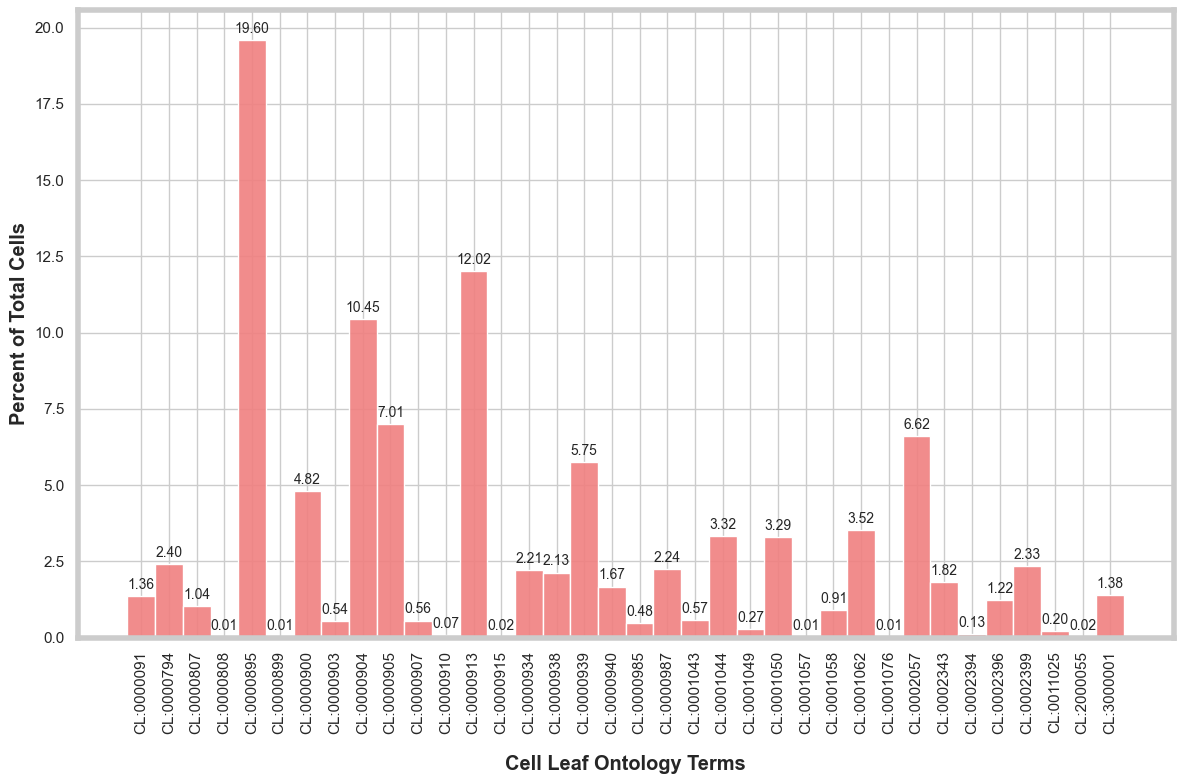

In [47]:
plt.figure(figsize=(12,8))


#sns.histplot(data=ids,stat='percent',color='lightcoral',alpha=0.9)
# stat can also be probability or percent

#plots = sns.barplot(x=keys, y=vals,color='lightcoral')#,errorbar = (stds))

plots = sns.histplot(data=ids,stat='percent',color='lightcoral',alpha=0.9)

# Iterating over the bars one-by-one
x = 0
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
    x += 1



plt.xticks(rotation=90)
plt.xlabel('Cell Leaf Ontology Terms',labelpad=15)
plt.ylabel('Percent of Total Cells')

plt.show()

## Visualze the distribution of leaf IDs over parents

In [11]:
# load the ontology
cl = Ontology.from_obo_library('cl.owl')

/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:289: SyntaxWarning: <Element '{http://purl.org/dc/elements/1.1/}description' at 0x7fb932547540> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:289: SyntaxWarning: <Element '{http://purl.org/dc/elements/1.1/}title' at 0x7fb932547770> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:289: SyntaxWarning: <Element '{http://www.w3.org/2002/07/owl#}versionInfo' at 0x7fb932547db0> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:113: SyntaxWarning: unknown elem

/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://purl.obolibrary.org/obo/}RO_0004050
  self._extract_term(class_, curies)
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://purl.org/dc/terms/}contributor
  self._extract_term(class_, curies)
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://xmlns.com/foaf/0.1/}depicted_by
  self._extract_term(class_, curies)
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://purl.obolibrary.org/obo/}IAO_0000028
  self._extract_term(class_, curies)
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/

/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/ontology.py:283: SyntaxWarning: unknown axiom property: 'http://purl.obolibrary.org/obo/IAO_0000118'
  cls(self).parse_from(_handle)  # type: ignore
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/ontology.py:283: SyntaxWarning: unknown axiom property: 'http://purl.obolibrary.org/obo/UBPROP_0000001'
  cls(self).parse_from(_handle)  # type: ignore
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/ontology.py:283: SyntaxWarning: unknown axiom property: 'http://purl.obolibrary.org/obo/UBPROP_0000003'
  cls(self).parse_from(_handle)  # type: ignore
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/ontology.py:283: SyntaxWarning: unknown axiom property: 'http://purl.obolibrary.org/obo/UBPROP_0000012'
  cls(self).parse_from(_handle)  # type: ignore
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/p

In [12]:
def preprocess_ontology(adata,target_column,upper_limit = None, include_leafs = False, cl_only = False, only_leafs_for_targets=False):
    '''
    This function processes the ontology to build a pandas dataframe that can be used to 
    calculate predicted probabilities. This will enable simple matrix multiplication to calculate
    probabilities and loss.
    
    Does not have a forced upper limit in the ontology.
    
    Assumes there is an active census object already open as cl. 
    
    
    Parameters
    ----------
    adata : AnnData Object
        existing AnnData object to perform processing on 
        
    target_column : string
        string of target column (from cell metadata) to encode
        
    upper_limit : string
        if you want to specify an upper limit in the ontology, set this to 
        the upper limit (inclusive)
        Default: None (no limit to ontology)
        
    include_leafs : boolean
        option to include leafs in the list of parent cell IDs
        Default is False because we are calculating the leaf loss differently
        Default: False
        
    cl_only : boolean
        option to only include the Cell Ontology (CL) in the dataframe
        True means only those cell IDs that start with CL are included
        Default: False
        
    only_leafs_for_targets : boolean
        option to specify that targets are already known to include leafs
        Default: False - program will check all targets and find any additional leafs
                True means that list of unique values in the target column will be used

        
    Returns
    -------
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are all leafs in portion of ontology being queried. 
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
    '''
    
    # select the labels. 
    labels = adata.obs
    
    # select the unique target values
    target_values = labels[target_column].unique()
    
    # check that these are leaf nodes
    # if not, find the leaf under that value
    
    if only_leafs_for_targets:
        leaf_nodes = target_values
    else:
        leaf_nodes = []
        for target in target_values:
            if cl[target].is_leaf():
                leaf_nodes.append(target)
            else:
                for term in cl[target].subclasses(distance=None,with_self=False).to_set():
                    if term.is_leaf():
                        leaf_nodes.append(term.id)
    
    # ensure that we do not have duplicate values
    leaf_nodes = list(set(leaf_nodes))
    
    
    # now get all parent nodes
    # if we want to include leafs, set with_self = True
    # else, set with_self = False
    parent_nodes = []
    for target in target_values:
        for term in cl[target].superclasses(distance=None,with_self=include_leafs).to_set():
            parent_nodes.append(term.id)
            
    # ensure that we do not have duplicate values
    parent_nodes = list(set(parent_nodes))

    # select only the Cell Ontology IDs if cl_only = True
    if cl_only:
        parent_nodes = [x for x in parent_nodes if x.startswith('CL')]
    
    # if there is an upper limit, 
    if upper_limit is not None:
        # get upper limit nodes
        upper_limit_nodes = []
        for term in cl[upper_limit].superclasses(distance=None,with_self=False).to_set():
            upper_limit_nodes.append(term.id)
            
        # remove these nodes from the parent_nodes list
        parent_nodes = [x for x in parent_nodes if x not in upper_limit_nodes]
        
    
    # create the dataframe
    ontology_df = pd.DataFrame(data=0, index = parent_nodes,
                                              columns = leaf_nodes)


    # populate the dataframe with 1 if column leaf is a leaf 
    # for that particular cell ID
    # with_self = True because we need to include the leafs here
    for cell_id in ontology_df.index:
        for term in cl[cell_id].subclasses(distance=None,with_self=True).to_set():
            if term.id in ontology_df.columns:
                ontology_df.loc[cell_id,[term.id]] = [1]
                    
    
    return(ontology_df)

In [15]:
target_column = 'cell_type_ontology_term_id'

upper_limit = 'CL:0000738' # leukocyte = 738

print('start preprocess ontology')
ontology_df = preprocess_ontology(adata,target_column,upper_limit = upper_limit, include_leafs = False, cl_only=True,only_leafs_for_targets=True)


start preprocess ontology


In [17]:
ontology_df['total'] = ontology_df.sum(axis=1)

In [26]:
percent_of_total = ontology_df['total']/36


In [28]:
percent_of_total.head()

CL:0001204    0.055556
CL:0001067    0.083333
CL:0000738    1.000000
CL:0001074    0.027778
CL:0011026    0.055556
Name: total, dtype: float64

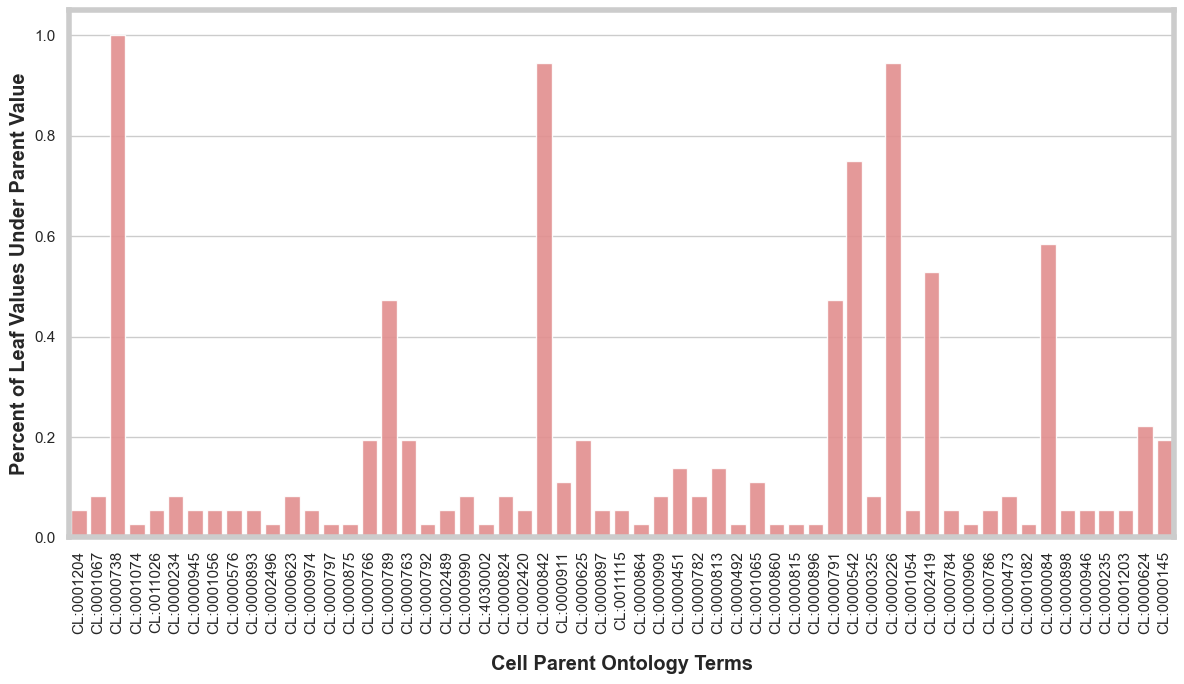

In [43]:
plt.figure(figsize=(12,7))


sns.barplot(data=ontology_df,x=ontology_df.index,y=ontology_df['total']/36,
            color='lightcoral',alpha=0.9)
# stat can also be probability or percent

plt.xticks(rotation=90)
plt.xlabel('Cell Parent Ontology Terms',labelpad=15)
plt.ylabel('Percent of Leaf Values Under Parent Value')

plt.show()